In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold

In [140]:
df = pd.read_excel('default.xls', header = 1) 

In [141]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [142]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

From the above, we notice that most of our variables are numeric, and the rest are categorical. We'll need to normalize the numeric variables and change the categorical variables into dummy variables.

In [143]:
df2 = pd.get_dummies(df, columns = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])

In [144]:
target = df2['default payment next month']

df2 = df2.drop(['default payment next month'], axis = 1)

In [145]:
numeric_vars = df2[['AGE', 'LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]

numeric_normalized = normalize(numeric_vars)

In [146]:
# Apply an additional log transformation because the distributions of 
# the numeric variables are still heavily skewed

df_normalized = pd.DataFrame(numeric_normalized)

for col in df_normalized.columns:
    # add a constant to avoid issues with log-transforming
    df_normalized[col] = df_normalized[col] + 1 
    df_normalized[col] = df_normalized[col].apply(np.log)

/Users/charlenechambliss/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


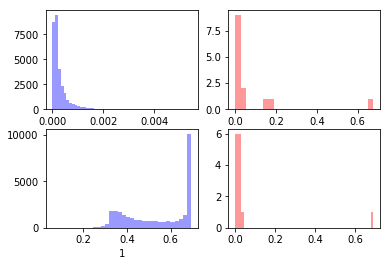

In [147]:
f, axes = plt.subplots(2, 2)
sns.distplot(df_normalized[0], kde=False, color="b", ax=axes[0, 0])
sns.distplot(numeric_normalized[0], kde=False, color="r", ax=axes[0, 1])
sns.distplot(df_normalized[1], kde=False, color="b", ax=axes[1, 0])
sns.distplot(numeric_normalized[1], kde=False, color="r", ax=axes[1, 1])

Blue represents a log-transformed variable, while red represents a variable that was normalized (forced to have a value between 0 and 1) but not log-transformed. The blue distributions clearly look somewhat smoother.

In [148]:
# all non-numeric columns
cat_vars = df2.drop(['AGE', 'LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'], axis = 1)

In [149]:
# Merge the data back together with 'ID'
df_normalized['ID'] = cat_vars['ID']
df_merged = pd.merge(cat_vars, df_normalized, on = 'ID')

In [150]:
keys = list(range(15))
names = numeric_vars.columns
columns_dict = dict(zip(keys, names))

df_merged = df_merged.rename(columns = columns_dict)

In [151]:
df_merged.head()

,ID,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,0,1,0,0,1,0,0,0,0,...,0.032841,0.000000,0.000000,0.000000,0.000000,0.032841,0.000000,0.000000,0.000000,0.000000
1,2,0,1,0,0,1,0,0,0,0,...,0.022060,0.026849,0.028329,0.026760,0.000000,0.008282,0.008282,0.008282,0.000000,0.016497
2,3,0,1,0,0,1,0,0,0,0,...,0.126922,0.133686,0.139059,0.144265,0.015037,0.014860,0.009931,0.009931,0.009931,0.048698
3,4,0,1,0,0,1,0,0,0,0,...,0.371664,0.229980,0.234649,0.238887,0.018100,0.018270,0.010899,0.009996,0.009715,0.009091
4,5,1,0,0,0,1,0,0,0,0,...,0.365567,0.229436,0.211715,0.211565,0.024333,0.372770,0.116143,0.105117,0.008450,0.008328


Now we have our full DataFrame appropriately transformed: all categorical variables have appropriate dummy variables, and all numerical variables have been normalized (and log-transformed) to have values between 0 and 1.

In [152]:
df_merged.columns

Index(['ID', 'SEX_1', 'SEX_2', 'EDUCATION_0', 'EDUCATION_1', 'EDUCATION_2',
       'EDUCATION_3', 'EDUCATION_4', 'EDUCATION_5', 'EDUCATION_6',
       'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3', 'PAY_0_-2',
       'PAY_0_-1', 'PAY_0_0', 'PAY_0_1', 'PAY_0_2', 'PAY_0_3', 'PAY_0_4',
       'PAY_0_5', 'PAY_0_6', 'PAY_0_7', 'PAY_0_8', 'PAY_2_-2', 'PAY_2_-1',
       'PAY_2_0', 'PAY_2_1', 'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5',
       'PAY_2_6', 'PAY_2_7', 'PAY_2_8', 'PAY_3_-2', 'PAY_3_-1', 'PAY_3_0',
       'PAY_3_1', 'PAY_3_2', 'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6',
       'PAY_3_7', 'PAY_3_8', 'PAY_4_-2', 'PAY_4_-1', 'PAY_4_0', 'PAY_4_1',
       'PAY_4_2', 'PAY_4_3', 'PAY_4_4', 'PAY_4_5', 'PAY_4_6', 'PAY_4_7',
       'PAY_4_8', 'PAY_5_-2', 'PAY_5_-1', 'PAY_5_0', 'PAY_5_2', 'PAY_5_3',
       'PAY_5_4', 'PAY_5_5', 'PAY_5_6', 'PAY_5_7', 'PAY_5_8', 'PAY_6_-2',
       'PAY_6_-1', 'PAY_6_0', 'PAY_6_2', 'PAY_6_3', 'PAY_6_4', 'PAY_6_5',
       'PAY_6_6', 'PAY_6_7', 'PAY_6_8', '

In [153]:
# X_train, X_test, y_train, y_test = train_test_split(df_merged, target, test_size = 0.2, random_state = 10)

# Use a stratified k-fold split since we have imbalanced classes
# (a much smaller number of defaults compared to non-defaults)

X = df_merged
y = target

# 70% of data goes to training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                    random_state = 10)

# Split training data into 3 folds
skf = StratifiedKFold(n_splits = 3, random_state = 10)

for train_index, test_index in skf.split(X_train, y_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

# Split remaining 30% into validation and test 
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.33, 
                                                    random_state = 10)

TRAIN: [ 6894  6899  6903 ... 20997 20998 20999] TEST: [   0    1    2 ... 7019 7020 7021]
TRAIN: [    0     1     2 ... 20997 20998 20999] TEST: [ 6894  6899  6903 ... 14027 14030 14032]
TRAIN: [    0     1     2 ... 14027 14030 14032] TEST: [13989 13992 13993 ... 20997 20998 20999]


# Model Selection

Now we're going to train a few different models on the training set. We will then test them out with a validation set and see if they still perform well. For the methods that do perform well, we'll go on to tune hyperparameters and test them on the test set.

*A quick note.* When reading classification reports for this dataset, we should keep in mind the following:

For defaults, the most important stat is recall, because it measures the ratio of true positives to (true positives + false negatives). A low ratio (close to 0) would then mean that many instances of default were missed, and were predicted not to be at risk. Meanwhile, a high ratio (closer to 1) would mean that almost all accounts at risk of default were identified successfully.

The ideal classifier would catch defaults almost always (a recall close to 1 for the Default class), even if it produced many false positives (low-ish precision for the Default class).

In [154]:
# Logistic Regression

logistic = LogisticRegression(solver = 'liblinear')
logistic.fit(X_train, y_train)

# calculate auc-roc
roc_auc_score(y_train, logistic.predict(X_train))

0.591182826373992

In [155]:
# calc again on validation set
roc_auc_score(y_val, logistic.predict(X_val))

0.6282897153351699

In [156]:
print("Logistic Regression performance:")
print()
print(classification_report(y_val, logistic.predict(X_val)), sep='\n')

Logistic Regression performance:

              precision    recall  f1-score   support

           0       0.82      0.96      0.88      3600
           1       0.68      0.30      0.42      1089

   micro avg       0.80      0.80      0.80      4689
   macro avg       0.75      0.63      0.65      4689
weighted avg       0.79      0.80      0.77      4689



In [157]:
# Decision tree classifier

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

# calc auc-roc
roc_auc_score(y_train, tree.predict(X_train))

1.0

In [158]:
# calc again on validation set
roc_auc_score(y_val, tree.predict(X_val))

# (score is not much better than chance - tree may have overfit data)

0.5821648301193756

In [159]:
print("Decision Tree performance:")
print()
print(classification_report(y_val, tree.predict(X_val)), sep='\n')

Decision Tree performance:

              precision    recall  f1-score   support

           0       0.81      0.71      0.76      3600
           1       0.32      0.46      0.38      1089

   micro avg       0.65      0.65      0.65      4689
   macro avg       0.57      0.58      0.57      4689
weighted avg       0.70      0.65      0.67      4689



In [160]:
# Naive Bayes

nb = GaussianNB()
nb.fit(X_train, y_train)

# calc auc-roc
roc_auc_score(y_train, nb.predict(X_train))

0.6475504743114956

In [161]:
# calc again on validation set
roc_auc_score(y_val, nb.predict(X_val))

0.6906875573921029

In [162]:
print("Naive Bayes performance:")
print()
print(classification_report(y_val, nb.predict(X_val)), sep='\n')

Naive Bayes performance:

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      3600
           1       0.62      0.47      0.53      1089

   micro avg       0.81      0.81      0.81      4689
   macro avg       0.73      0.69      0.71      4689
weighted avg       0.80      0.81      0.80      4689



Of all the models, it looks like the Naive Bayes classifier has the strongest performance. There is not much to tune for a Naive Bayes classifier, so we'll go ahead and evaluate on the test set.

In [163]:
# Test set performace
print("AUC-ROC score: " + str(roc_auc_score(y_test, nb.predict(X_test))))
print()
print(classification_report(y_test, nb.predict(X_test)), sep='\n')

AUC-ROC score: 0.6890772983053333

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1748
           1       0.63      0.47      0.54       562

   micro avg       0.80      0.80      0.80      2310
   macro avg       0.73      0.69      0.71      2310
weighted avg       0.79      0.80      0.79      2310



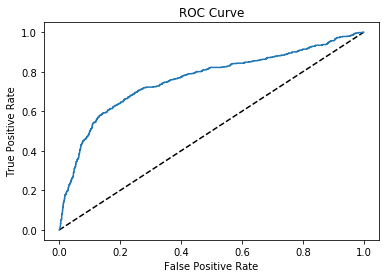

In [164]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = nb.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

It's worth noting that I also ran this analysis with the numerical variables only normalized (that is, I did not log-transform them) and got the same result for AUC-ROC as well as for the classification reports. Although the numerical variables appeared to have skewed distributions before the log-transformation, it did not have a noticeable effect on the models' predictions.